In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [31]:
BASE_PATH = "/kaggle/input/datasets/kmader/skin-cancer-mnist-ham10000"

metadata = pd.read_csv(os.path.join(BASE_PATH, "HAM10000_metadata.csv"))

image_dir1 = os.path.join(BASE_PATH, "HAM10000_images_part_1")
image_dir2 = os.path.join(BASE_PATH, "HAM10000_images_part_2")

def get_image_path(image_id):
    path1 = os.path.join(image_dir1, image_id + ".jpg")
    path2 = os.path.join(image_dir2, image_id + ".jpg")
    return path1 if os.path.exists(path1) else path2

metadata["path"] = metadata["image_id"].apply(get_image_path)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/datasets/kmader/skin-cancer-mnis...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/datasets/kmader/skin-cancer-mnis...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/datasets/kmader/skin-cancer-mnis...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/datasets/kmader/skin-cancer-mnis...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/datasets/kmader/skin-cancer-mnis...


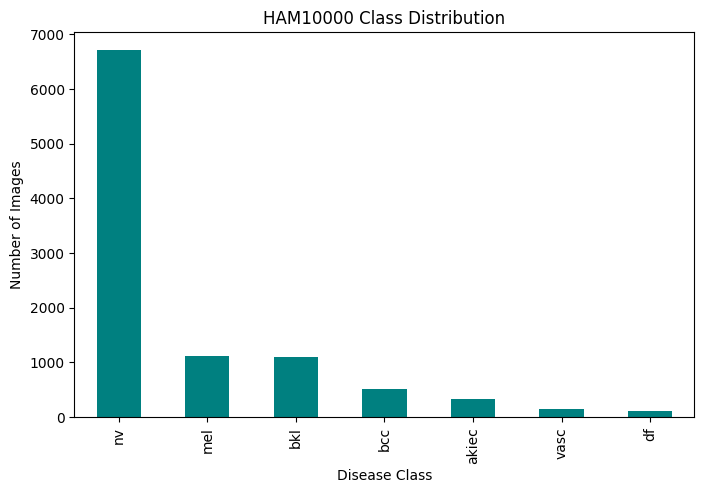

In [33]:
plt.figure(figsize=(8,5))
metadata['dx'].value_counts().plot(kind='bar',color='teal')
plt.title("HAM10000 Class Distribution")
plt.xlabel("Disease Class")
plt.ylabel("Number of Images")
plt.show()

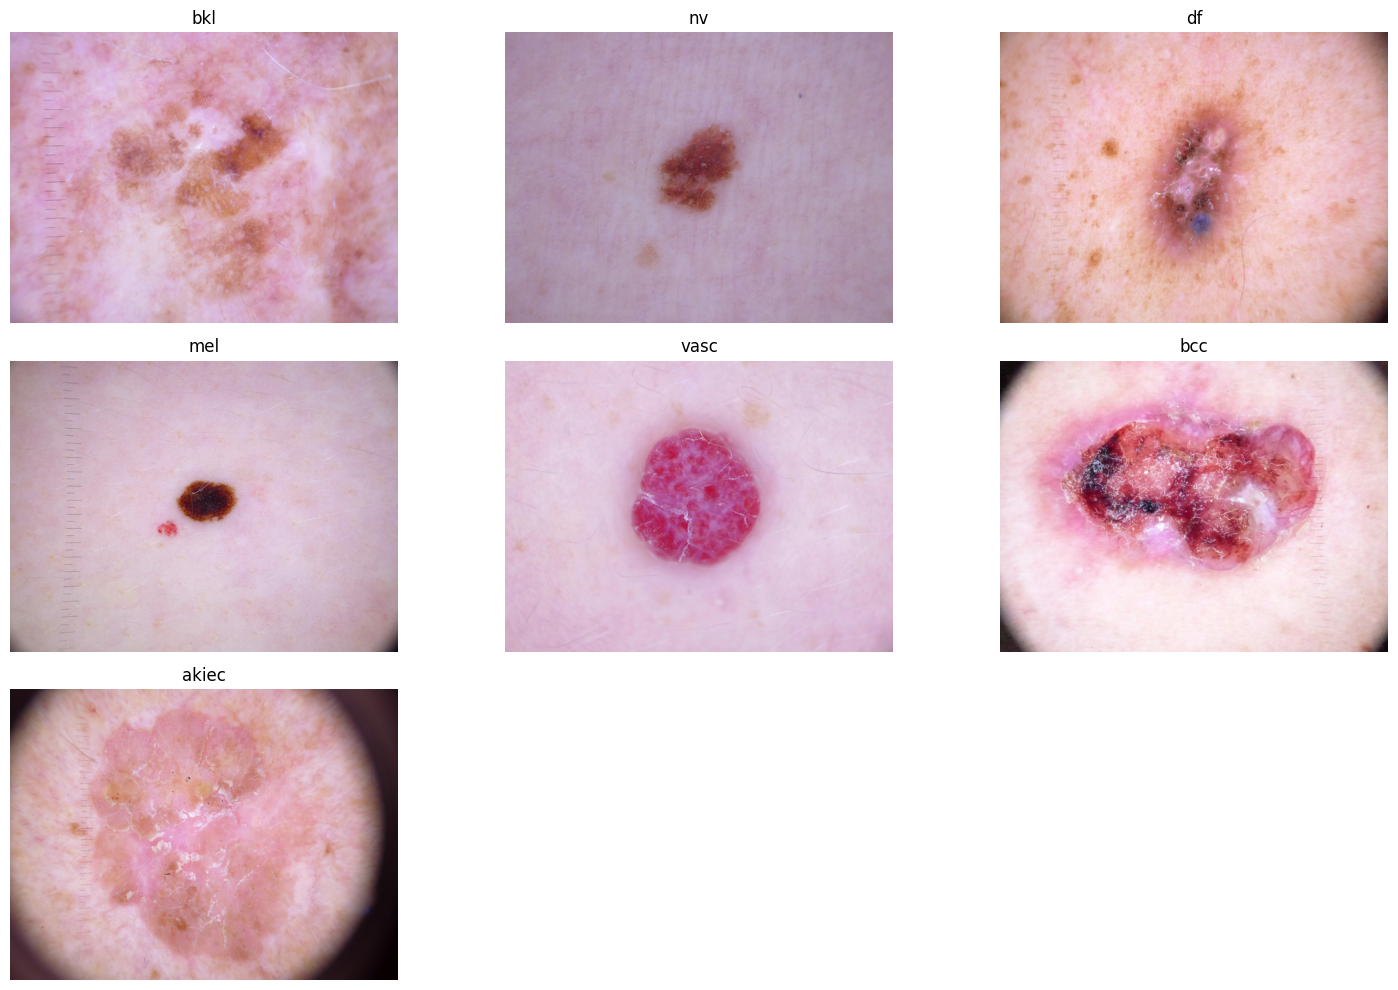

In [34]:
classes = metadata['dx'].unique()

plt.figure(figsize=(15,10))

for i, cls in enumerate(classes):
    sample = metadata[metadata['dx'] == cls].iloc[0]
    img = cv2.imread(sample['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [35]:
train_df, temp_df = train_test_split(
    metadata,
    test_size=0.3,
    stratify=metadata['dx'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['dx'],
    random_state=42
)

In [36]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7,1.3]
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE
)

num_classes = len(train_generator.class_indices)

Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


In [37]:
train_labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights))

print("Class Mapping:", train_generator.class_indices)
print("Class Weights:", class_weights)

Class Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Class Weights: {0: np.float64(4.37305053025577), 1: np.float64(2.7817460317460316), 2: np.float64(1.3022478172023035), 3: np.float64(12.36331569664903), 4: np.float64(1.285530900421786), 5: np.float64(0.21338772031292808), 6: np.float64(10.115440115440116)}


In [38]:
tf.keras.backend.clear_session()

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

for layer in base_model.layers[:-30]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 14,976,519 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [39]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 159s 649ms/step - accuracy: 0.4171 - loss: 1.7982 - val_accuracy: 0.7297 - val_loss: 0.7945 - learning_rate: 1.0000e-04
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 133s 604ms/step - accuracy: 0.6283 - loss: 0.9161 - val_accuracy: 0.4214 - val_loss: 1.5843 - learning_rate: 1.0000e-04
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 135s 614ms/step - accuracy: 0.5598 - loss: 0.8349 - val_accuracy: 0.7177 - val_loss: 0.7929 - learning_rate: 1.0000e-04
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 133s 603ms/step - accuracy: 0.7113 - loss: 0.6477 - val_accuracy: 0.6937 - val_loss: 0.8014 - learning_rate: 1.0000e-04
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7276 - loss: 0.5955
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
220/220 ━━━━━━━━━━━━━━━━━━━━ 133s 602ms/step - accuracy: 0.7275 - loss: 0.5956 - val_accuracy: 0.6884 - val_loss: 0.9197 - learning_rate: 1.0000e-04
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 133s 6

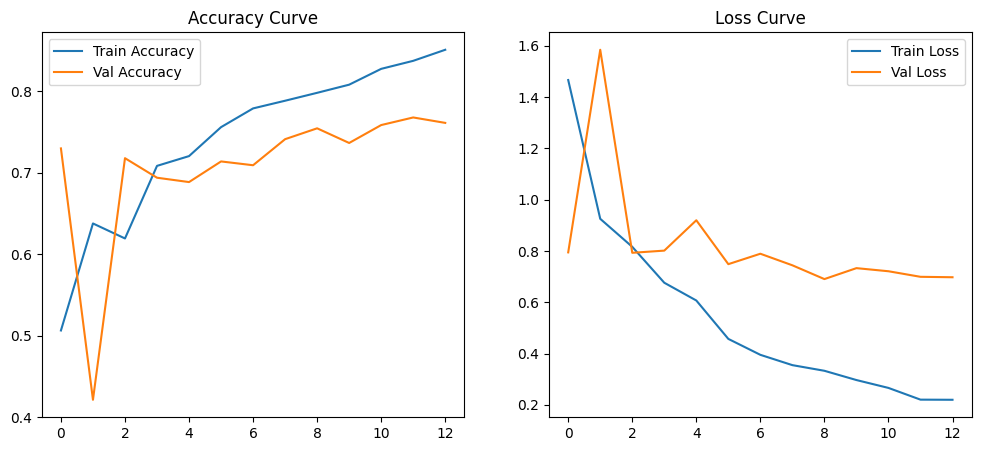

In [40]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.show()

In [41]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 600ms/step - accuracy: 0.7563 - loss: 0.7410
Test Accuracy: 0.7498336434364319


In [42]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes))

47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 337ms/step
              precision    recall  f1-score   support

           0       0.90      0.39      0.54        49
           1       0.68      0.73      0.70        77
           2       0.46      0.84      0.59       165
           3       0.43      0.59      0.50        17
           4       0.45      0.75      0.56       167
           5       0.98      0.76      0.85      1006
           6       0.78      0.82      0.80        22

    accuracy                           0.75      1503
   macro avg       0.67      0.69      0.65      1503
weighted avg       0.84      0.75      0.77      1503

